# Introduction

The objective of this notebook is the Multi-Class Prediction of Obesity Risk Playground Series - Season 4, Episode 2 dataset.

We start with an exploratory data analysis and continue according to the gained insights with feature engineering. 

Finally we are going to implement and train a tree based model using the XGBoost algorithm.

The hyperparameters of the model will be tuned using the Optuna algorithm.

# Imports

To be able to analyse the the dataset and to develop our models we first have to import the following libraries. 

Train shape: (22869, 18)
Test shape: (13840, 17)
Categorical features: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS']
Numerical features: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']


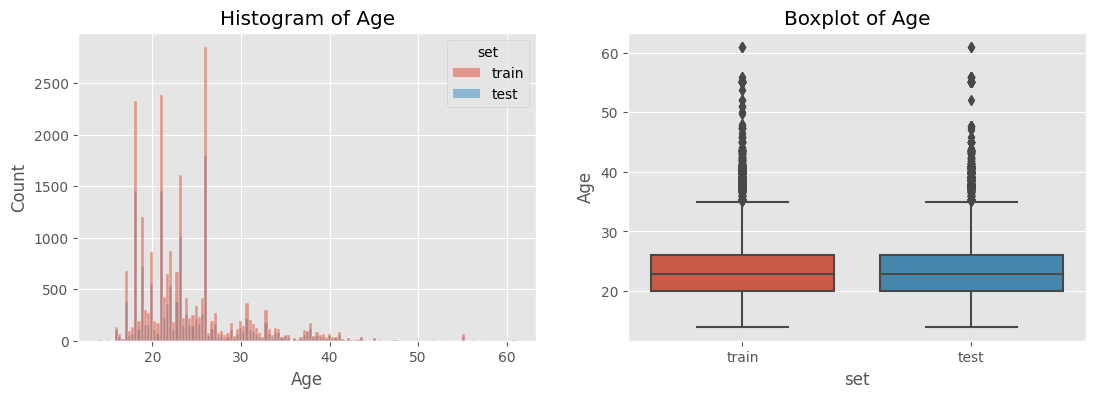

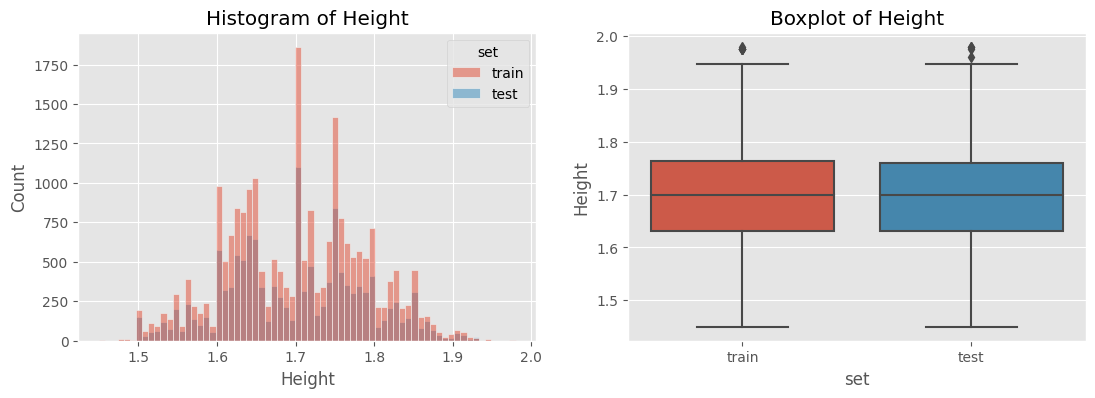

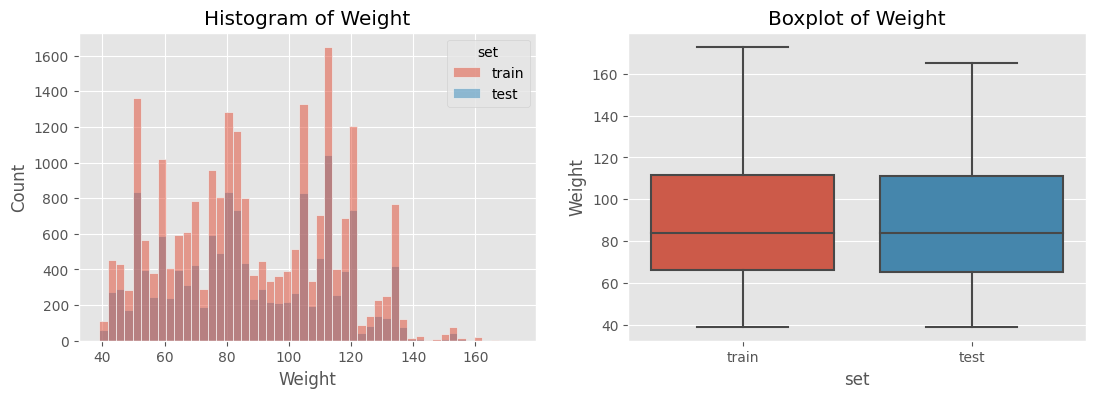

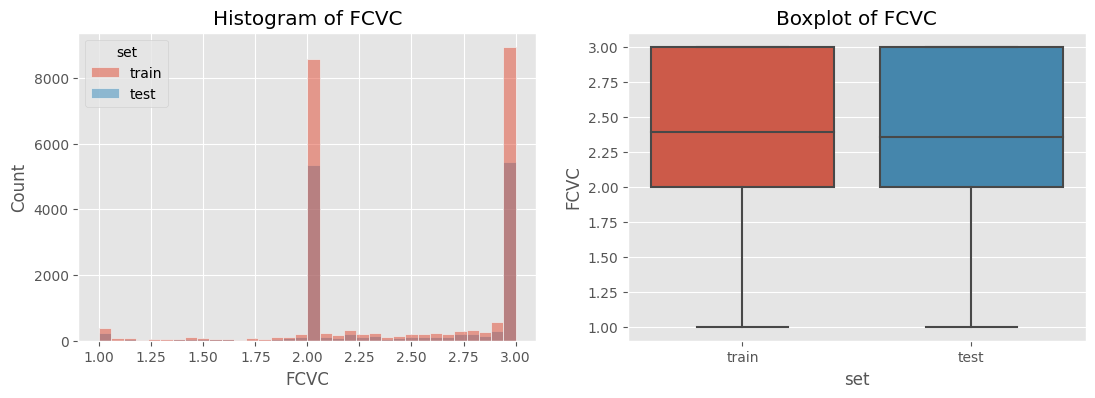

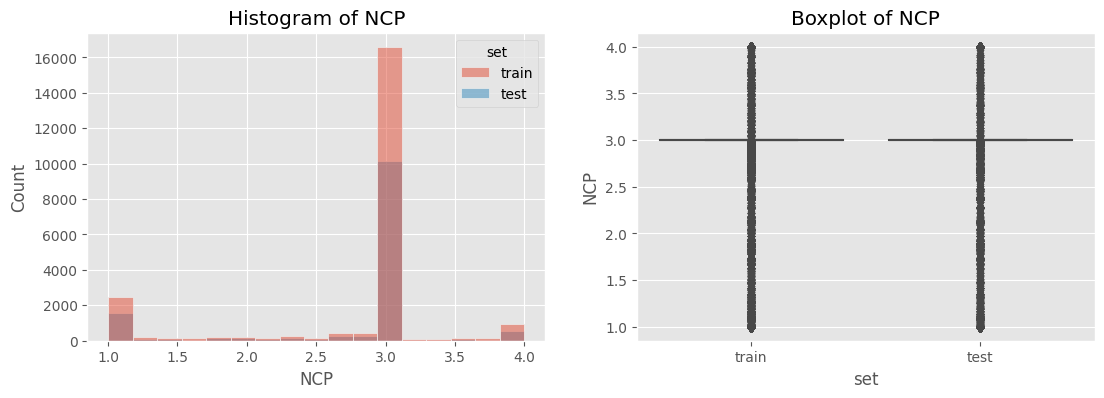

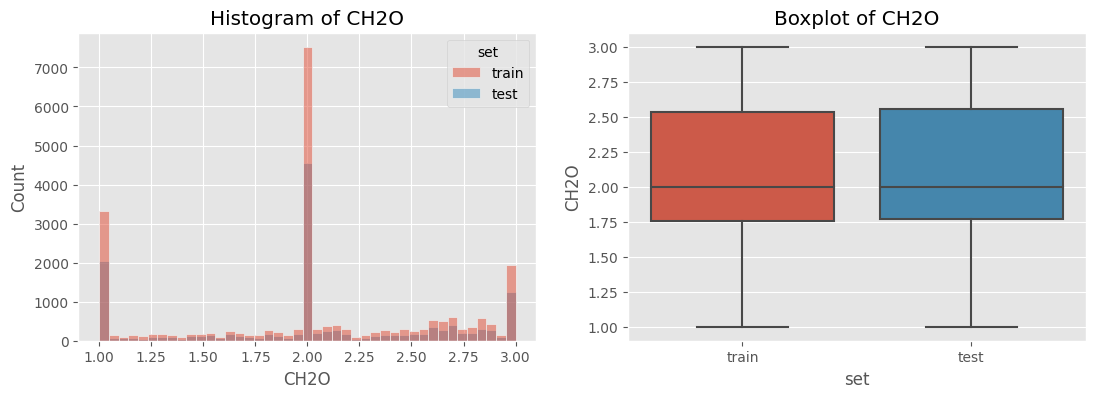

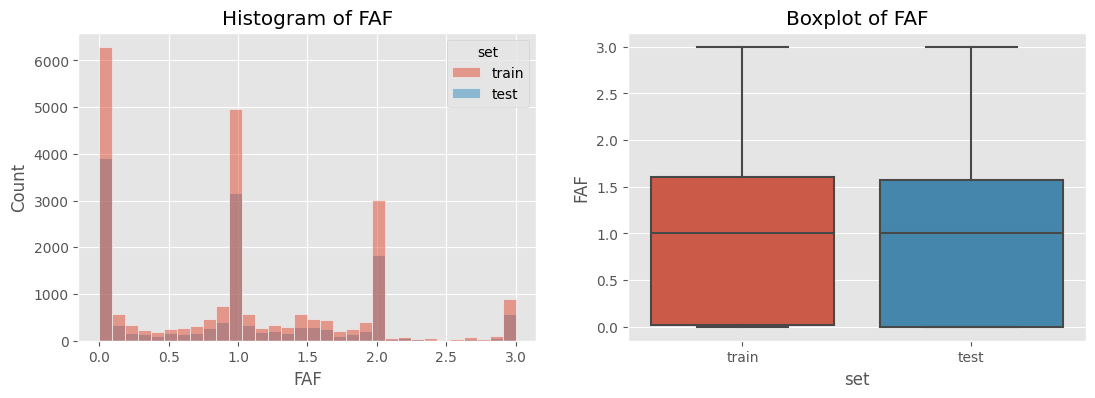

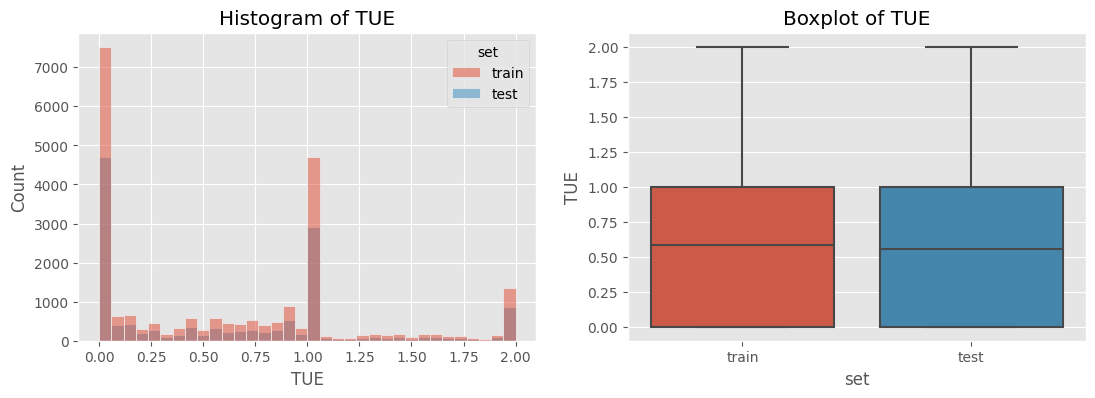

Correlation with target:
 Weight                            0.896382
family_history_with_overweight    0.507723
Age                               0.356665
CAEC                              0.354491
FCVC                              0.289197
CH2O                              0.247825
FAF                               0.223323
CALC                              0.207421
SCC                               0.183722
FAVC                              0.178037
Height                            0.156911
TUE                               0.126218
Walking                           0.111386
Public_Transportation             0.056925
Gender                            0.050188
NCP                               0.041323
Motorbike                         0.030942
Bike                              0.027820
SMOKE                             0.012790
Automobile                        0.009492
dtype: float64
[0]	validation_0-mlogloss:1.92316	validation_1-mlogloss:1.92345
[100]	validation_0-mlogloss:0.88105

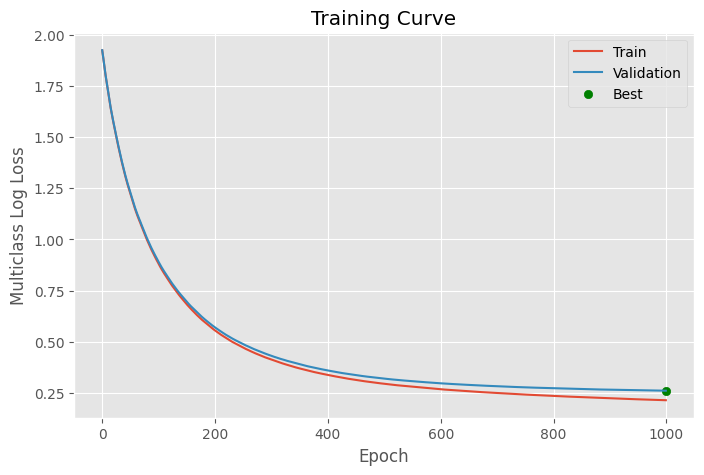

Macro AUC: 0.9910
Micro AUC: 0.9938


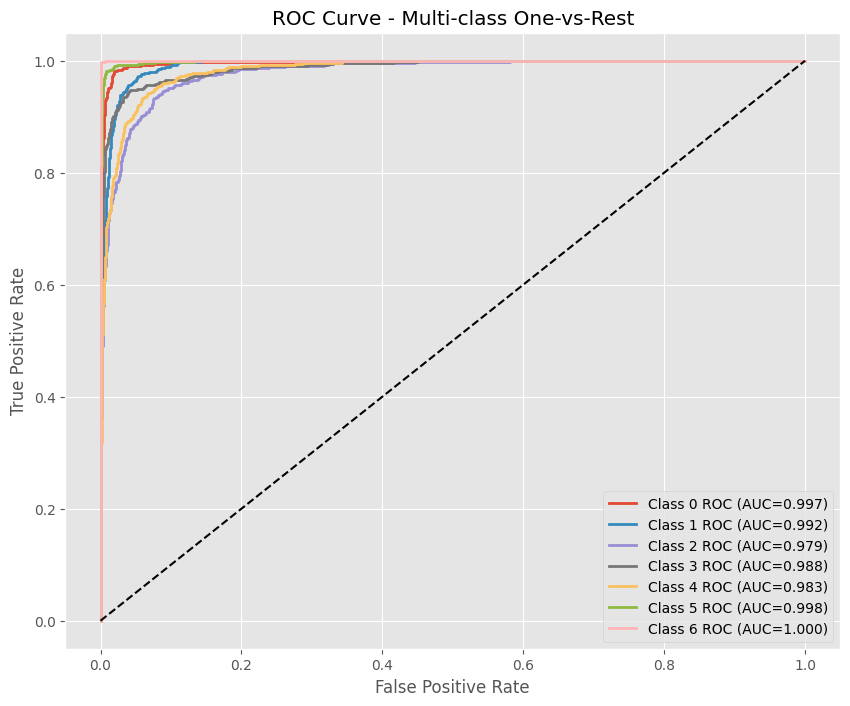


=== Training XGB: lr=0.01, max_depth=4 ===

=== Training XGB: lr=0.01, max_depth=5 ===

=== Training XGB: lr=0.01, max_depth=7 ===

=== Training XGB: lr=0.05, max_depth=4 ===

=== Training XGB: lr=0.05, max_depth=5 ===

=== Training XGB: lr=0.05, max_depth=7 ===

=== Training XGB: lr=0.1, max_depth=4 ===

=== Training XGB: lr=0.1, max_depth=5 ===

=== Training XGB: lr=0.1, max_depth=7 ===

=== Training XGB: lr=0.15, max_depth=4 ===

=== Training XGB: lr=0.15, max_depth=5 ===

=== Training XGB: lr=0.15, max_depth=7 ===

=== Training XGB: lr=0.2, max_depth=4 ===

=== Training XGB: lr=0.2, max_depth=5 ===

=== Training XGB: lr=0.2, max_depth=7 ===

=== Parameter Tuning Results ===
    learning_rate  max_depth  accuracy       auc
4            0.05          5  0.914642  0.991594
6            0.10          4  0.915080  0.991505
3            0.05          4  0.913548  0.991473
5            0.05          7  0.915518  0.991340
7            0.10          5  0.913548  0.991265
9            0.15 

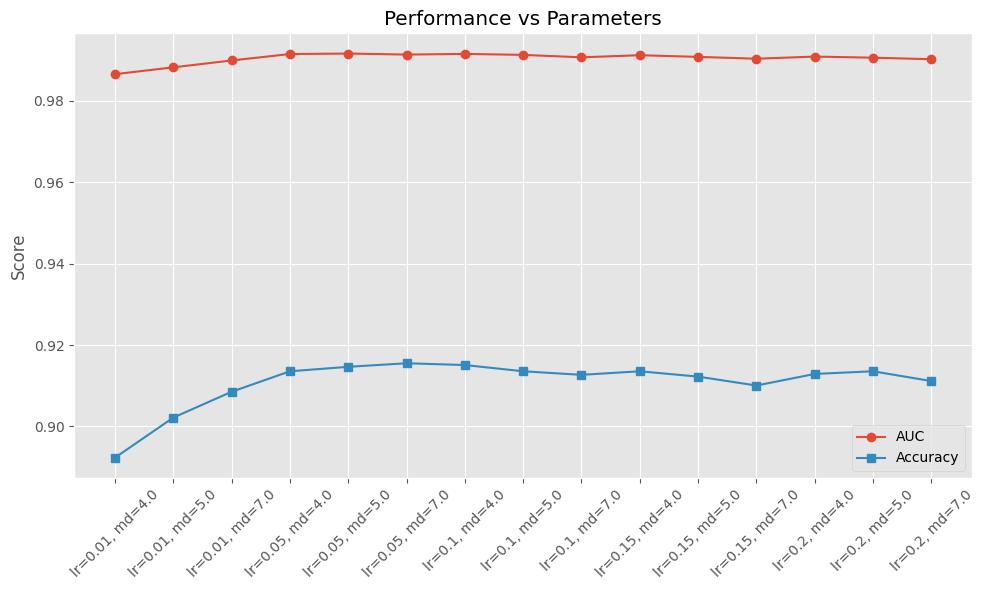

Fold 1: Acc=0.9151, AUC=0.9911, F1_macro=0.9069
Fold 2: Acc=0.9133, AUC=0.9910, F1_macro=0.9046
Fold 3: Acc=0.9118, AUC=0.9904, F1_macro=0.9030
Fold 4: Acc=0.9109, AUC=0.9908, F1_macro=0.9018
Fold 5: Acc=0.9135, AUC=0.9909, F1_macro=0.9052

=== Cross-Validation Summary ===
Accuracy:       0.9129 ± 0.0014
Macro AUC:      0.9909 ± 0.0003
F1 (macro):     0.9043 ± 0.0018
F1 (weighted):  0.9127 ± 0.0014
F1 (micro):     0.9129 ± 0.0014
MAE:            0.1263 ± 0.0031
MSE:            0.2162 ± 0.0089
CV Accuracy: 0.912934996717006
CV AUC: 0.9908500426412864


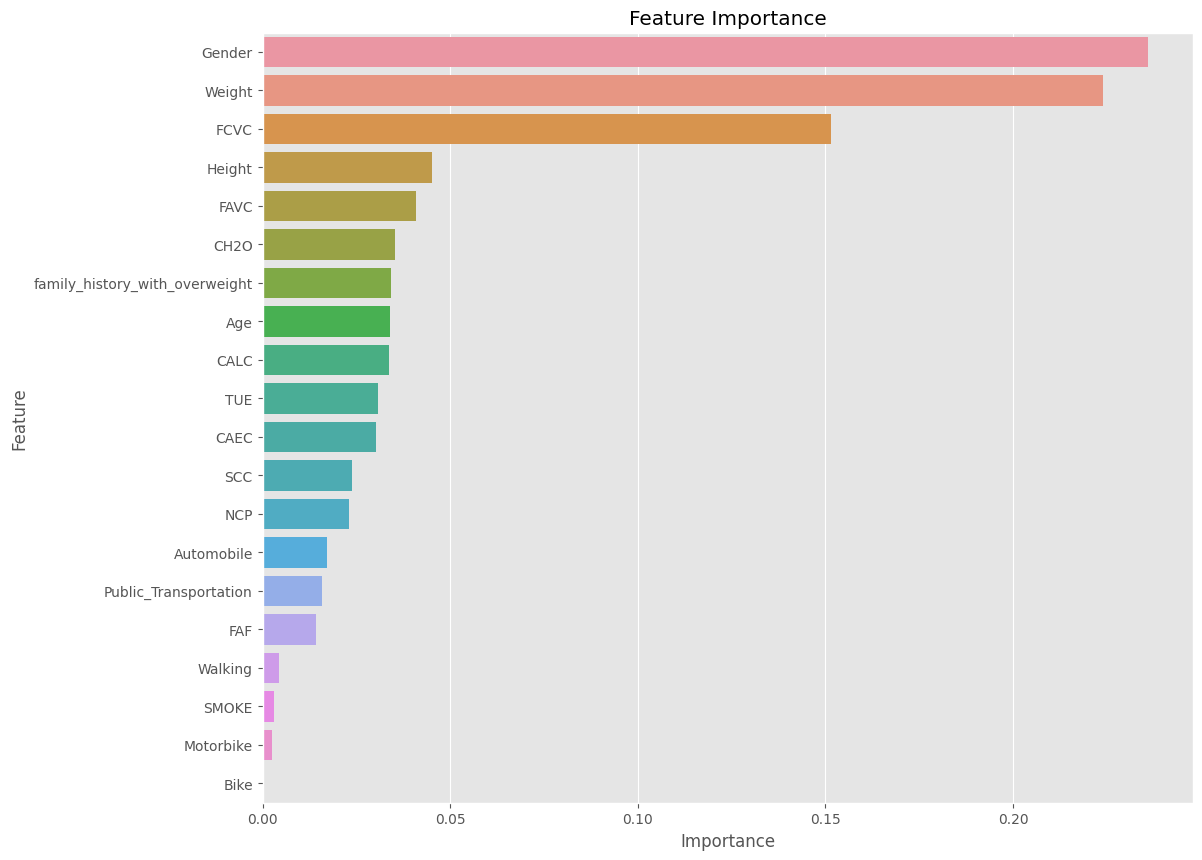

Saved submission.csv successfully.


In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier

warnings.filterwarnings("ignore")
plt.style.use("ggplot")

# ===========================================
# Load data
# ===========================================

path = "/kaggle/input/playground-series-s4e2"

train = pd.read_csv(f"{path}/train.csv")
test = pd.read_csv(f"{path}/test.csv")
submission = pd.read_csv(f"{path}/sample_submission.csv")

original_train = pd.read_csv(
    "/kaggle/input/obesity-or-cvd-risk-classifyregressorcluster/ObesityDataSet.csv"
)

train = pd.concat([train, original_train], axis=0)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# ===========================================
# Remove duplicates
# ===========================================
train.drop_duplicates(inplace=True)

# ===========================================
# Target separation
# ===========================================
target = train["NObeyesdad"]

train.drop(columns=["id", "NObeyesdad"], inplace=True)
test_id = test["id"]
test.drop(columns=["id"], inplace=True)

# ===========================================
# DROP HEIGHT COMPLETELY
# ===========================================

# ===========================================
# Categorical & numerical features
# ===========================================

categorical_features = train.select_dtypes(include=["object"]).columns
numerical_features = train.select_dtypes(include=["float64", "int64"]).columns

print("Categorical features:", list(categorical_features))
print("Numerical features:", list(numerical_features))

# ===========================================
# Plot numerical distributions
# ===========================================

def plot_distribution_pairs(train_df, test_df, feature):
    df = train_df.copy()
    df["set"] = "train"
    df = pd.concat([df, test_df.copy()])
    df["set"].fillna("test", inplace=True)

    fig, ax = plt.subplots(1, 2, figsize=(13, 4))
    sns.histplot(data=df, x=feature, hue="set", ax=ax[0])
    sns.boxplot(data=df, x="set", y=feature, ax=ax[1])

    ax[0].set_title(f"Histogram of {feature}")
    ax[1].set_title(f"Boxplot of {feature}")
    plt.show()


for feature in numerical_features:
    plot_distribution_pairs(train, test, feature)

# ===========================================
# Feature Engineering
# ===========================================

feature_dict = {
    "Gender": {"Female": 0, "Male": 1},
    "family_history_with_overweight": {"no": 0, "yes": 1},
    "FAVC": {"no": 0, "yes": 1},
    "CAEC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
    "SMOKE": {"no": 0, "yes": 1},
    "SCC": {"no": 0, "yes": 1},
    "CALC": {"no": 0, "Sometimes": 1, "Frequently": 2, "Always": 3},
}

target_categories = [
    "Insufficient_Weight",
    "Normal_Weight",
    "Overweight_Level_I",
    "Obesity_Type_I",
    "Overweight_Level_II",
    "Obesity_Type_II",
    "Obesity_Type_III",
]

obesity_dict = {label: i for i, label in enumerate(target_categories)}
inverse_obesity_dict = {i: label for i, label in enumerate(target_categories)}

# Merge for encoding
all_df = pd.concat([train, test], keys=[0, 1], axis=0)

# Apply encoding
for feature in categorical_features:
    if feature == "MTRANS":
        onehot = pd.get_dummies(all_df[feature])
        all_df = pd.concat([all_df, onehot], axis=1)
        all_df.drop(columns=[feature], inplace=True)
    else:
        all_df[feature] = all_df[feature].map(feature_dict[feature])

train = all_df.xs(0)
test = all_df.xs(1)
target = target.map(obesity_dict)

# ===========================================
# Correlation with target
# ===========================================

corr = train.corrwith(target).abs().sort_values(ascending=False)
print("Correlation with target:\n", corr)

# ===========================================
# Train-validation split
# ===========================================

X = train
y = target
X_test = test

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ===========================================
# Model training
# ===========================================

def fit_plot(model, X_train, y_train, X_val, y_val, verbose=100):
    eval_set = [(X_train, y_train), (X_val, y_val)]
    model.fit(X_train, y_train, eval_set=eval_set, verbose=verbose)

    acc_train = accuracy_score(y_train, model.predict(X_train))
    acc_val = accuracy_score(y_val, model.predict(X_val))

    print(f"Train Accuracy: {acc_train:.4f}")
    print(f"Val Accuracy:   {acc_val:.4f}")

    results = model.evals_result()

    val_loss = results["validation_1"]["mlogloss"]
    best_loss = min(val_loss)
    best_epoch = val_loss.index(best_loss)

    plt.figure(figsize=(8, 5))
    plt.plot(results["validation_0"]["mlogloss"], label="Train")
    plt.plot(results["validation_1"]["mlogloss"], label="Validation")
    plt.scatter(best_epoch, best_loss, color="green", label="Best")
    plt.xlabel("Epoch")
    plt.ylabel("Multiclass Log Loss")
    plt.title("Training Curve")
    plt.legend()
    plt.show()


xgb_0 = XGBClassifier(
    learning_rate=0.01,
    n_estimators=1000,
    early_stopping_rounds=50,
    max_depth=5,
    reg_alpha = 1,      # L1 regularization
    reg_lambda = 2,     # L2 regularization
    min_child_weight = 3,
    gamma=0,
    colsample_bytree=0.8,
    subsample=0.8,
    objective="multi:softprob",
    eval_metric="mlogloss",
    nthread=-1,
    random_state=42
)

fit_plot(xgb_0, X_train, y_train, X_val, y_val)

from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Multi-class needs one-vs-rest
y_val_bin = label_binarize(y_val, classes=np.arange(7))

# Predict probabilities
y_val_proba = xgb_0.predict_proba(X_val)

# Compute AUC
macro_auc = roc_auc_score(y_val_bin, y_val_proba, multi_class="ovr", average="macro")
micro_auc = roc_auc_score(y_val_bin, y_val_proba, multi_class="ovr", average="micro")

print(f"Macro AUC: {macro_auc:.4f}")
print(f"Micro AUC: {micro_auc:.4f}")

# Plot ROC curves per class
plt.figure(figsize=(10, 8))
for i in range(7):
    fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    plt.plot(fpr, tpr, lw=2, label=f"Class {i} ROC (AUC={auc(fpr,tpr):.3f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Multi-class One-vs-Rest")
plt.legend()
plt.show()

param_grid = {
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2],
    "max_depth": [4, 5, 7],
}

results_list = []

for lr in param_grid["learning_rate"]:
    for md in param_grid["max_depth"]:
        print(f"\n=== Training XGB: lr={lr}, max_depth={md} ===")
        
        model_tmp = XGBClassifier(
            learning_rate=lr,
            n_estimators=400,
            max_depth=md,
            min_child_weight=3,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42
        )
        
        model_tmp.fit(X_train, y_train)
        
        # predictions
        y_pred = model_tmp.predict(X_val)
        y_pred_proba = model_tmp.predict_proba(X_val)
        
        # metrics
        acc_tmp = accuracy_score(y_val, y_pred)
        auc_tmp = roc_auc_score(label_binarize(y_val, classes=np.arange(7)),
                                y_pred_proba,
                                multi_class="ovr",
                                average="macro")
        
        results_list.append({
            "learning_rate": lr,
            "max_depth": md,
            "accuracy": acc_tmp,
            "auc": auc_tmp
        })

results_df = pd.DataFrame(results_list)
print("\n=== Parameter Tuning Results ===")
print(results_df.sort_values("auc", ascending=False))

plt.figure(figsize=(10,6))
plt.plot(results_df["auc"], marker="o", label="AUC")
plt.plot(results_df["accuracy"], marker="s", label="Accuracy")
plt.xticks(ticks=range(len(results_df)),
           labels=[f"lr={row['learning_rate']}, md={row['max_depth']}"
                   for _, row in results_df.iterrows()],
           rotation=45)
plt.title("Performance vs Parameters")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score, roc_auc_score, f1_score,
    mean_absolute_error, mean_squared_error
)
from sklearn.preprocessing import label_binarize

def cross_validate_xgb(params, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)

    acc_scores, auc_scores = [], []
    f1_macro_scores, f1_weighted_scores, f1_micro_scores = [], [], []
    mae_scores, mse_scores = [], []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), 1):
        X_tr, X_va = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_va = y.iloc[train_idx], y.iloc[val_idx]

        model = XGBClassifier(
            **params,
            objective="multi:softprob",
            eval_metric="mlogloss",
            random_state=42
        )
        model.fit(X_tr, y_tr)

        # Predictions
        y_pred = model.predict(X_va)
        y_pred_proba = model.predict_proba(X_va)

        # Accuracy
        acc = accuracy_score(y_va, y_pred)
        acc_scores.append(acc)

        # Macro AUC
        y_va_bin = label_binarize(y_va, classes=np.arange(7))
        auc_fold = roc_auc_score(
            y_va_bin, y_pred_proba,
            multi_class="ovr", average="macro"
        )
        auc_scores.append(auc_fold)

        # F1 scores
        f1_macro_scores.append(f1_score(y_va, y_pred, average="macro"))
        f1_weighted_scores.append(f1_score(y_va, y_pred, average="weighted"))
        f1_micro_scores.append(f1_score(y_va, y_pred, average="micro"))

        # Regression-type metrics on encoded labels
        mae_scores.append(mean_absolute_error(y_va, y_pred))
        mse_scores.append(mean_squared_error(y_va, y_pred))

        print(f"Fold {fold}: "
              f"Acc={acc:.4f}, AUC={auc_fold:.4f}, "
              f"F1_macro={f1_macro_scores[-1]:.4f}")

    print("\n=== Cross-Validation Summary ===")
    print(f"Accuracy:       {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
    print(f"Macro AUC:      {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
    print(f"F1 (macro):     {np.mean(f1_macro_scores):.4f} ± {np.std(f1_macro_scores):.4f}")
    print(f"F1 (weighted):  {np.mean(f1_weighted_scores):.4f} ± {np.std(f1_weighted_scores):.4f}")
    print(f"F1 (micro):     {np.mean(f1_micro_scores):.4f} ± {np.std(f1_micro_scores):.4f}")
    print(f"MAE:            {np.mean(mae_scores):.4f} ± {np.std(mae_scores):.4f}")
    print(f"MSE:            {np.mean(mse_scores):.4f} ± {np.std(mse_scores):.4f}")

    return {
        "accuracy": np.mean(acc_scores),
        "auc": np.mean(auc_scores),
        "f1_macro": np.mean(f1_macro_scores),
        "f1_micro": np.mean(f1_micro_scores),
        "f1_weighted": np.mean(f1_weighted_scores),
        "mae": np.mean(mae_scores),
        "mse": np.mean(mse_scores)
    }
    
params = {
    "learning_rate": 0.01,
    "n_estimators": 1000,
    "max_depth": 5,
    "min_child_weight": 3,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "gamma": 0,
}

cv_results = cross_validate_xgb(params, X, y, folds=5)

cv_acc = cv_results["accuracy"]
cv_auc = cv_results["auc"]

print("CV Accuracy:", cv_acc)
print("CV AUC:", cv_auc)

# ===========================================
# Feature Importance
# ===========================================

fi = xgb_0.feature_importances_
fi_df = pd.DataFrame({"Feature": X.columns, "Importance": fi})
fi_df = fi_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x="Importance", y="Feature", data=fi_df)
plt.title("Feature Importance")
plt.show()

# ===========================================
# Submission file
# ===========================================

pred = xgb_0.predict(X_test)
submission["NObeyesdad"] = pred
submission["NObeyesdad"] = submission["NObeyesdad"].map(inverse_obesity_dict)

submission.to_csv("submission.csv", index=False)

print("Saved submission.csv successfully.")